### PH464/564: Scientific Computing II
***J.S. Hazboun***
#### Katelyn Ebert
___

# Lecture/Homework 03
### Due: Friday, October 18th at 11:59pm Pacific
---

# HW 3

The purpose of this assignment is to get exercise some basic sampling skills, focusing on rejection and importance sampling.

Take the following probability density function:
```math
p(x) = 0.164\exp{\left(-\frac{(x-10)^4}{2\cdot 8^2}\right)}
```

1. Use _rejection sampling_ to draw 1000 samples from this distribution.  Show that the samples you've drawn are correctly distributed according to this probability density function.

2. Use _importance sampling_ to estimate the expectation value of $x$, and compare it to the mean of the samples you drew in part 1.

3. Calculate the expectation value of $x^2$.

4. Return to the Sampling section of the `Lecture_4_multivar_central.ipynb` and work through the examples there. 

## Grad students:

5. Revisit the importance sampling example from the Intro to Sampling notebook from class.  There we demonstrated the use of importance sampling to estimate the expectation value of some function of our random variable.  We could also use the weights we computed to probabilistically choose samples from the sampling distribution to keep, in an effort to "reweigh" the sampling distribution to correspond to the target distribution.  Try to implement this, and see if your resampled distribution's histogram matches the target distribution's probability density function.


In [50]:
# All the imports!
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
import math
import seaborn as sns

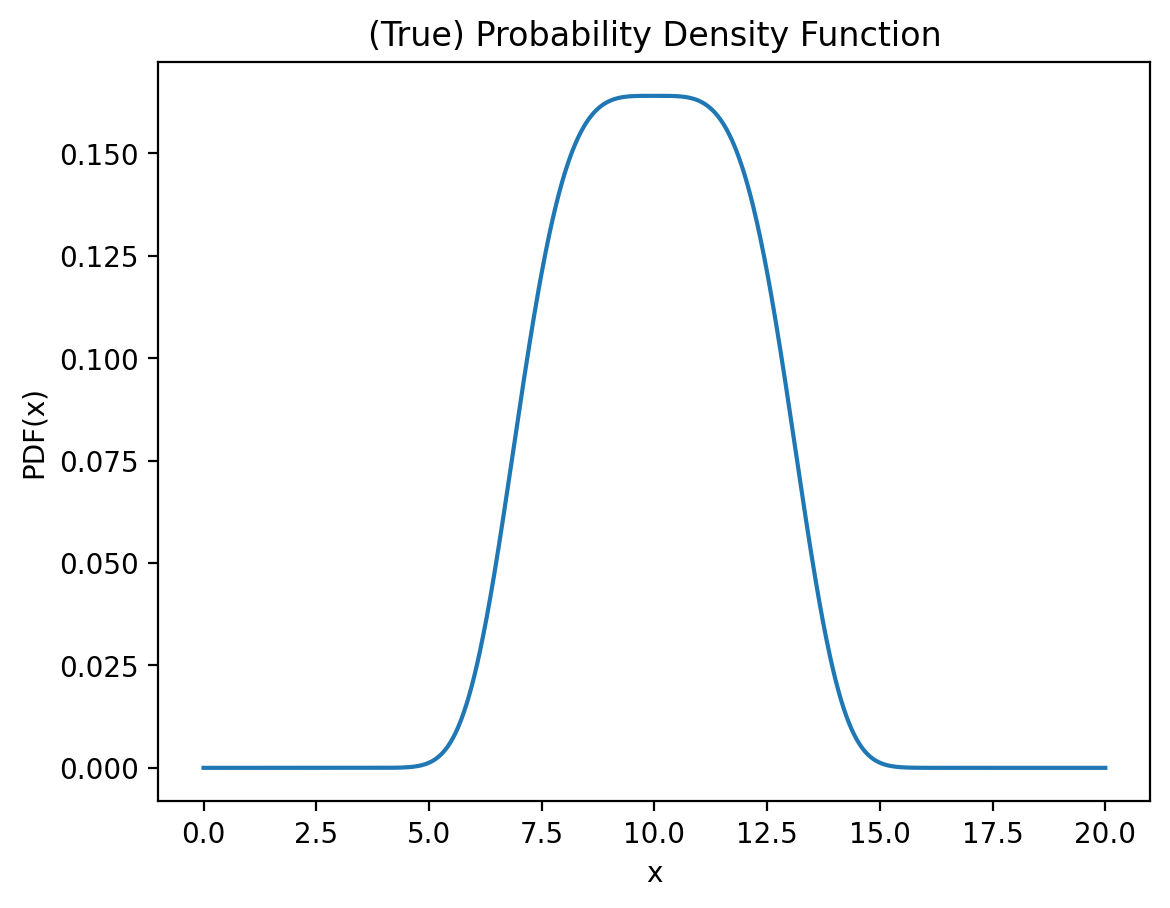

In [51]:
def p(x):
    return(0.164*math.e**((-(x-10)**4)/128)) # the True PDF(x)

x = np.linspace(0,20,1000) # a list of x-values that encompass the interesting parts of our function
plt.plot(x,p(x)) # plot it
plt.xlabel('x')
plt.ylabel('PDF(x)')
plt.title('(True) Probability Density Function')
plt.show()

In [52]:
# Define our distribution for sampling
def g(x):
    '''A distribution we can draw samples from'''
    return np.ones_like(x) # they're all ones to start with :)

k = max(p(x) / g(x)) # define our rescaling factor
print(k)

0.16399999998713613


In [53]:
# yoinking our definition of rejection sampling from the lecture notes
def rejection_sampling(iter=1000):
    samples = []

    for i in range(iter):
        z = np.random.uniform(0, 20) # random number within the bounds of our true pdf
        u = np.random.uniform(0, k*g(z)) # scaled to be a random number from within our (scaled) range

        if u <= p(z):
            samples.append(z) # here's the rejection part; if the sample is within the pdf's range, it stays

    return np.array(samples)  # and our sample array

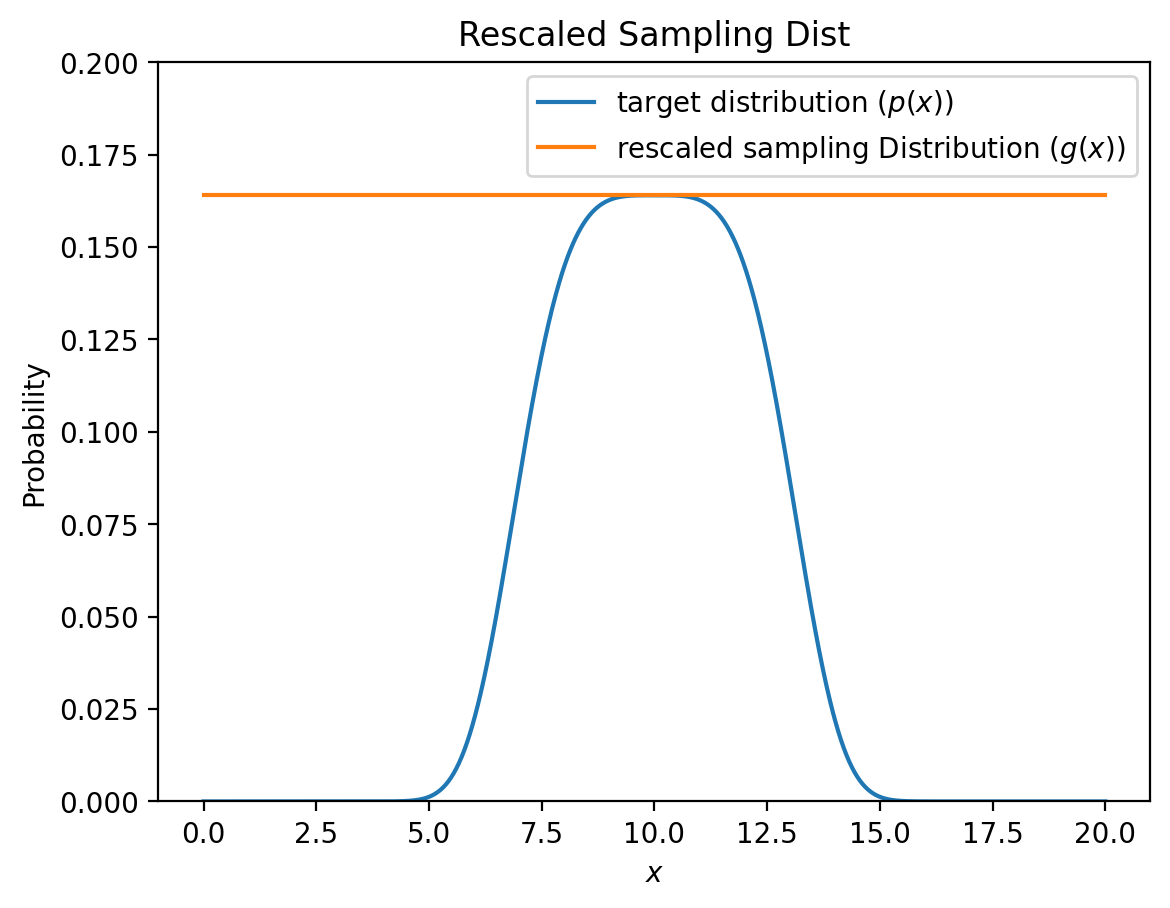

In [54]:
plt.plot(x, p(x), label='target distribution ($p(x)$)')
plt.plot(x, k*g(x), label='rescaled sampling Distribution ($g(x)$)')

plt.ylim(0, 0.2) # make the y-values not obnoxious
plt.legend()
plt.xlabel('$x$');
plt.ylabel('Probability')
plt.title('Rescaled Sampling Dist')
plt.show()

In [82]:
s = rejection_sampling(iter=3500) # mess about with the number of iteratons til we get the desire 1000 samples
print("{} samples drawn from target distribution".format(len(s)))

1081 samples drawn from target distribution


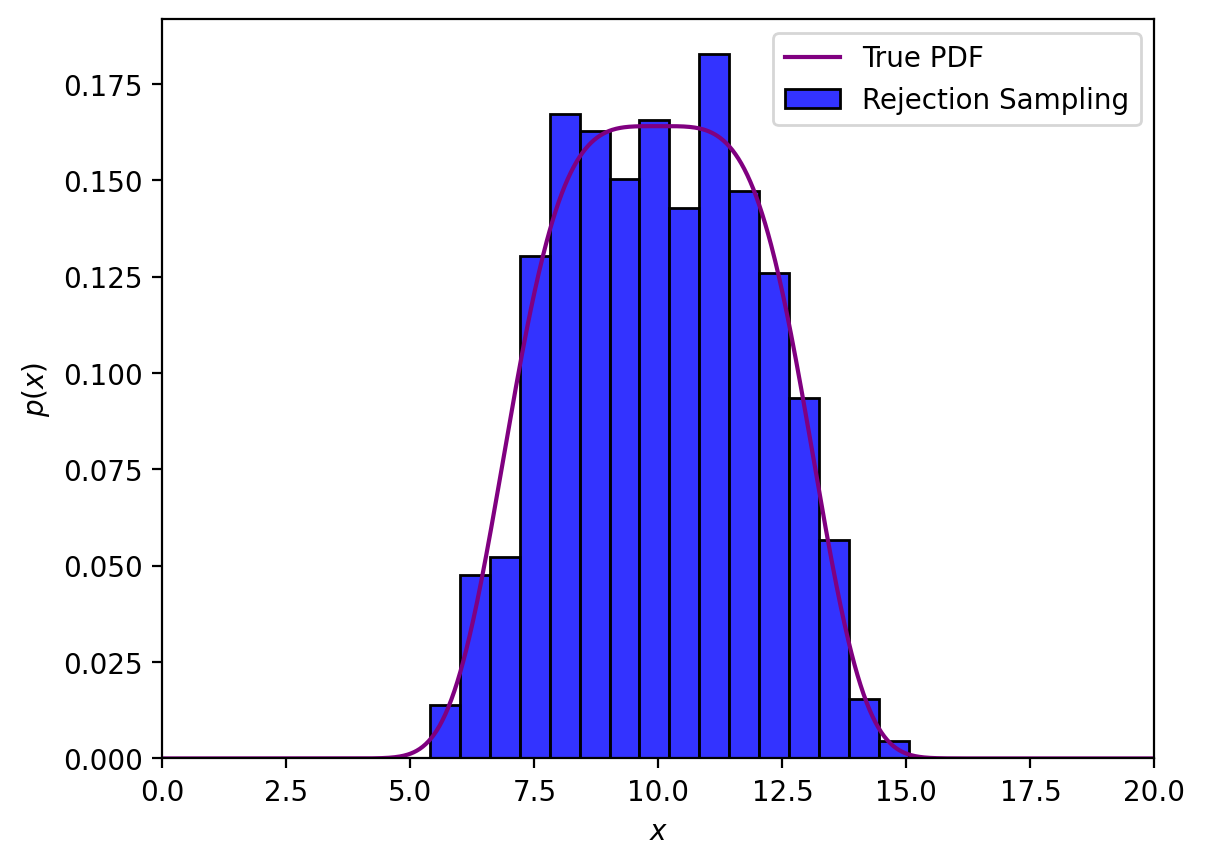

In [87]:
sns.histplot(s, stat='density', alpha=0.8, color='blue', label = 'Rejection Sampling')
plt.plot(x, p(x), color='purple', label = 'True PDF')
plt.xlim(0, 20)
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.legend();

This is a really good match between our sampled distribution and the true distribution. You can see the same general behavior!

## Problem 2: Importance Sampling
Now we do this for importance sampling

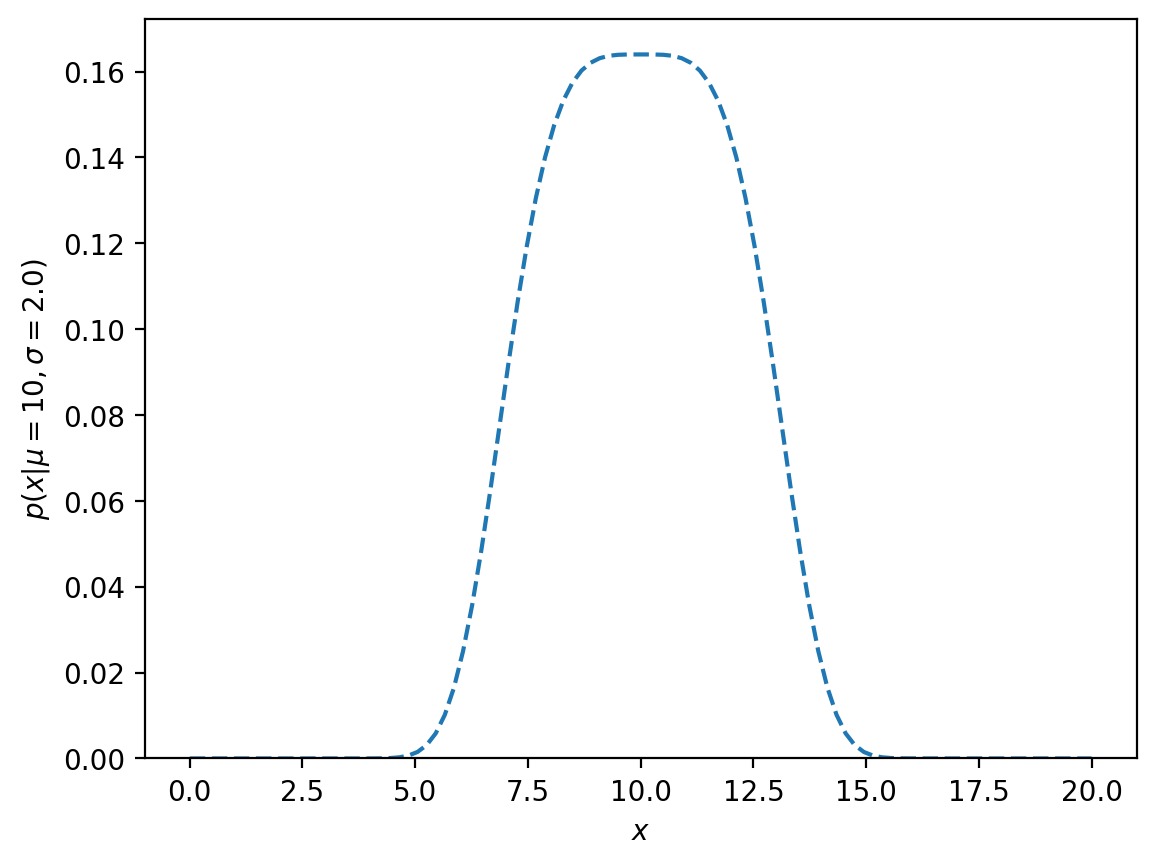

In [88]:
# We'll want a normal distribution to pull from to recreate our pdf with
mu = 10 
sigma = 2.
xs = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)

plt.plot(xs, p(xs), ls='--')
plt.ylim(ymin=0)

plt.ylabel(r'$p(x|\mu={}, \sigma={})$'.format(mu, sigma))
plt.xlabel('$x$');

In [63]:
def q(x):
    '''An unnormalized PDF'''
    return p(x) # since we've already defined our true probability density function

# Define our sampling distribution g(x) as a random variable X_g
μ_g = mu
σ_g = 3 * sigma
X_g = norm(loc=μ_g, scale=σ_g)

In [64]:
S = 10000 # number of draws
x_gs = X_g.rvs(S) # select draws randomly for our gaussian
ws = q(x_gs)/X_g.pdf(x_gs) # define our importance weight in terms of the random draws

In [89]:
E_x = np.sum(x_gs * ws)/np.sum(ws) # calculate our expectation value
print(E_x)

9.997715755115777


In [66]:
## Comparing to the mean of our Rejection Sampling
np.mean(s)

np.float64(9.990473317410796)

And it's a match with our average from the rejection sampling! Yay!

## Problem 3: Alternative Expectation Value

In lecture, and up until now, we had set the expectation value $h(\theta) = \theta$, but now we set $h(x) = x^2$. This will be substituted into our $E_x$ calculation to replace $x_s$. 

So:
$$
E(h(x)|y) = \frac{\frac{1}{S}\sum_{s=1}^S h(x^s) w(x^s)}{\frac{1}{S}\sum_{s=1}^S w(x^s)}
$$
(Kalista pointed this out to me)

In [68]:
def h(x):
    return x**2 # defining expectation value of h(x) as x^2
h_x = h(x_gs) # running it for x_gs 

In [72]:
# Running the E(h(x)|y) calculation
ws = q(x_gs)/X_g.pdf(x_gs)
E_x = np.sum(h_x * ws)/np.sum(ws)
print(E_x)

103.78190018878132


Okay! But this doesn't match our previous rejection sampling case. Well, that makes sense, because our expectation value has been scaled. Since our pdf is pretty gaussian, mean and median are the same. So scaling the entire distribution shouldn't destroy this Perhaps the mean of our original sample squared will be similar?

In [78]:
np.mean(s)**2

np.float64(100.05964935177849)

And, it is. At least within 3% accuracy. Cool!

## Problem 4
In Notebooks

## Problem 5: Reweighting

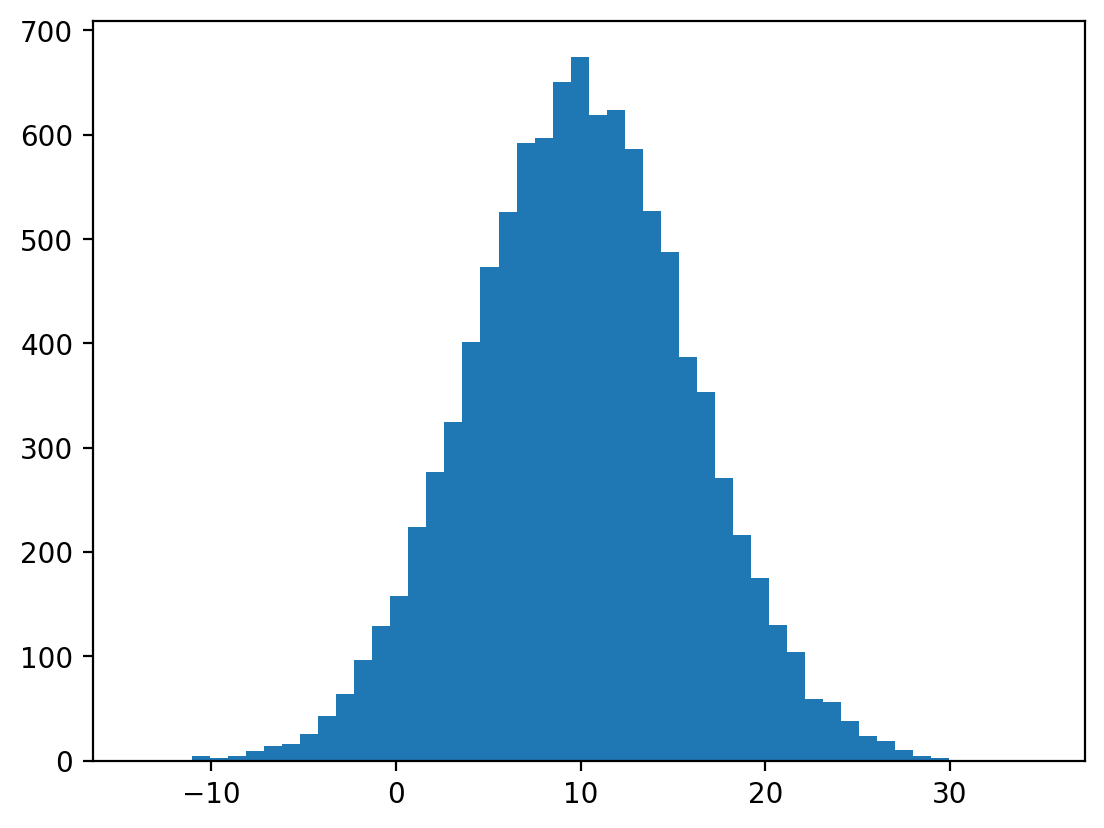

In [79]:
plt.hist(x_gs, bins=50); # let's plot a histogram of our 

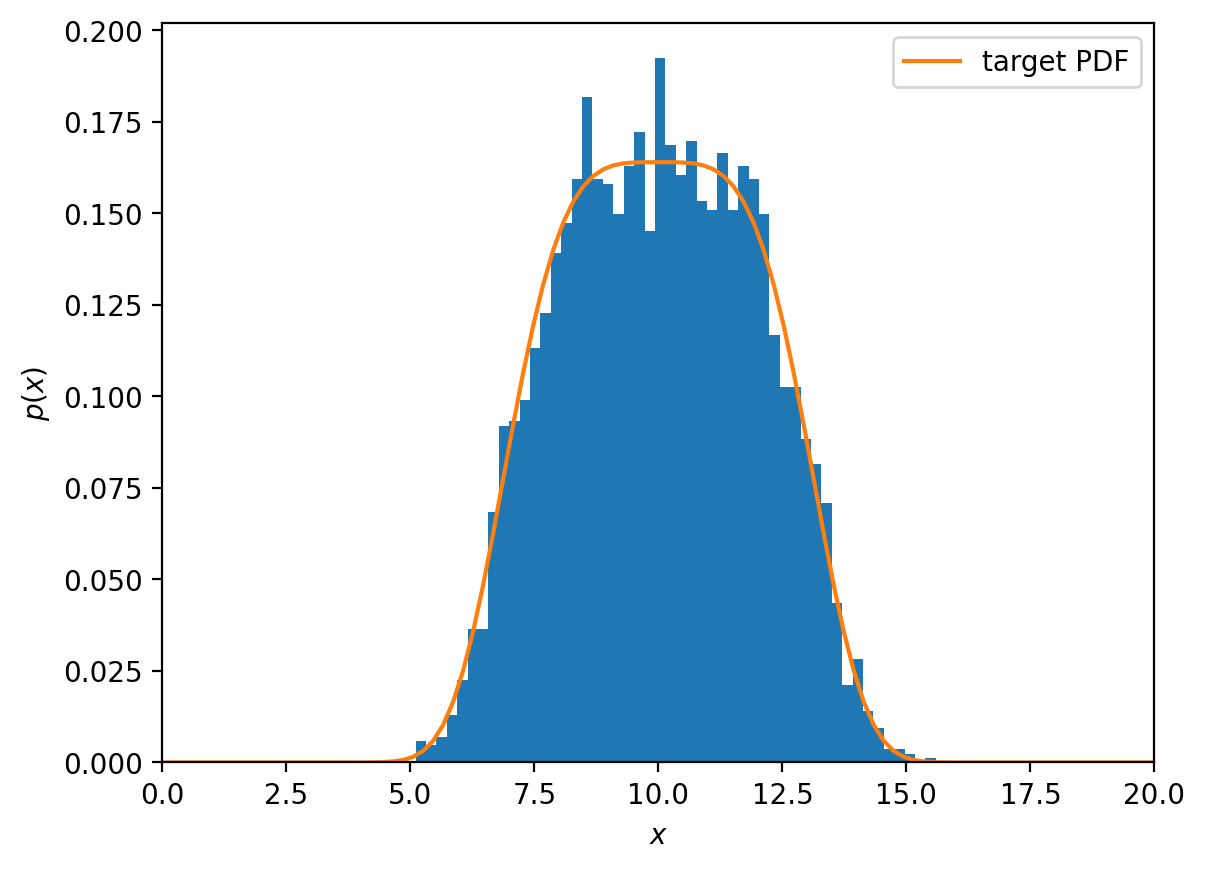

In [80]:
w_max = np.max(ws) # this gives something we can scale by; our maximum of the weighting function
sel = np.random.uniform(0, w_max, S) < ws # here, we only choose options less than our maximum weight function
plt.hist(x_gs[sel], bins=50, density=True); # plot again for comparison
plt.plot(xs, p(xs), label='target PDF')
plt.legend()
plt.xlim(0, 20)
plt.xlabel('$x$')
plt.ylabel('$p(x)$');

This is a very fine grain distribution and approximates our original quite well after only 1000 iterations. 